*   Qingyi (Freda) Song Drechsler's code on Momentum  
* based on CRSP data and Jegadeesh & Titman (1993) Momentum Portfolio
*  https://www.fredasongdrechsler.com/python-code/momentum

In [23]:
# 1) First, As always, import the various Python data packages and establish connection with WRDS server 

import pandas as pd
import numpy as np
import wrds                          # Install it via Spyder by typing:  pip install wrds
import matplotlib.pyplot as plt
from pandas.tseries.offsets import *
from scipy import stats

###################
# Connect to WRDS #;  it will prompt fpr enter user name and password 
###################
conn=wrds.Connection()     #it will prompt fpr enter user name and password

Enter your WRDS username [zhou]:qqqolin
Enter your password:········
WRDS recommends setting up a .pgpass file.
You can find more info here:
https://www.postgresql.org/docs/9.5/static/libpq-pgpass.html.
Loading library list...
Done


In [24]:
# 2)  The next step is to extract data from CRSP database

###################
# CRSP Block      #
###################
# sql similar to crspmerge macro
# added exchcd=-2,-1,0 to address the issue that stocks temp stopped trading
# without exchcd=-2,-1, 0 the non-trading months will be tossed out in the output
# leading to wrong cumret calculation in momentum step
# Code  Definition
# -2 Halted by the NYSE or AMEX
# -1 Suspended by the NYSE, AMEX, or NASDAQ
# 0 Not Trading on NYSE, AMEX, or NASDAQ
# 1 New York Stock Exchange
# 2 American Stock Exchange

crsp_m = conn.raw_sql("""
                      select a.permno, a.permco, b.ncusip, a.date, 
                      b.shrcd, b.exchcd, b.siccd,
                      a.ret, a.vol, a.shrout, a.prc, a.cfacpr, a.cfacshr
                      from crsp.msf as a
                      left join crsp.msenames as b
                      on a.permno=b.permno
                      and b.namedt<=a.date
                      and a.date<=b.nameendt
                      where a.date between '01/01/1963' and '12/31/1989'
                      and b.exchcd between -2 and 2
                      and b.shrcd between 10 and 11
                      """) 

                         # Note: One can change the time period above '01/01/1963' and '12/31/1989'
    
# Change variable format to int
crsp_m[['permco','permno','shrcd','exchcd']]=\
    crsp_m[['permco','permno','shrcd','exchcd']].astype(int)

# Line up date to be end of month
crsp_m['date']=pd.to_datetime(crsp_m['date'])

 #  pd.DataFrame.to_csv(crsp_m,'crsp.csv')
 

   # may write it out:  pd.DataFrame.to_csv(crsp_m,'crsp.csv')      # write output to a file
       # or add the full path to the code, like pd.DataFrame.to_csv(crsp_m,'D:/crsp.csv')
   #  Then read in:   crsp_m = pd.read_csv('crsp.csv')
   # this way no need to login in the data base everytime runs the analysis 
    
print('Done Step 2:  extract  data  \n')

Done Step 2:  extract  data  



In [13]:
 # 3)  With the data ready, then calculate the cumulative return by summing log returns.
          #There can be many other methods to arrive at the same goal. 
    
#######################################################
# Create Momentum Portfolio                           #
# Measures Based on Past (J) Month Compounded Returns #
#######################################################

J = 6 # Formation Period Length: J can be between 3 to 12 months
K = 6 # Holding Period Length: K can be between 3 to 12 months

_tmp_crsp = crsp_m[['permno','date','ret']].sort_values(['permno','date'])\
    .set_index('date')

# Replace missing return with 0
_tmp_crsp['ret']=_tmp_crsp['ret'].fillna(0)

# Calculate rolling cumulative return
# by summing log(1+ret) over the formation period
_tmp_crsp['logret']=np.log(1+_tmp_crsp['ret'])
umd = _tmp_crsp.groupby(['permno'])['logret'].rolling(J, min_periods=J).sum()
umd = umd.reset_index()
umd['cumret']=np.exp(umd['logret'])-1

print('Done Step 3:  compute the returns  \n')

Done Step 3:  compute the returns  



In [4]:
# 4)  Form momentum portfolios

########################################
# Formation of 10 Momentum Portfolios  #
########################################

# For each date: assign ranking 1-10 based on cumret
# 1=lowest 10=highest cumret

umd=umd.dropna(axis=0, subset=['cumret'])
umd['momr']=umd.groupby('date')['cumret'].transform(lambda x: pd.qcut(x, 10, labels=False))

umd.momr=umd.momr.astype(int)
umd['momr'] = umd['momr']+1

# Corrected previous version month end line up issue
# First lineup date to month end date medate
# Then calculate hdate1 and hdate2 using medate

umd['form_date'] = umd['date']
umd['medate'] = umd['date']+MonthEnd(0)
umd['hdate1']=umd['medate']+MonthBegin(1)
umd['hdate2']=umd['medate']+MonthEnd(K)
umd = umd[['permno', 'form_date','momr','hdate1','hdate2']]

# join rank and return data together
# note: this step consumes a lot of memory so takes a while
_tmp_ret = crsp_m[['permno','date','ret']]
port = pd.merge(_tmp_ret, umd, on=['permno'], how='inner')
port = port[(port['hdate1']<=port['date']) & (port['date']<=port['hdate2'])]

umd2 = port.sort_values(by=['date','momr','form_date','permno']).drop_duplicates()
umd3 = umd2.groupby(['date','momr','form_date'])['ret'].mean().reset_index()

# Skip first two years of the sample 
start_yr = umd3['date'].dt.year.min()+2
umd3 = umd3[umd3['date'].dt.year>=start_yr]
umd3 = umd3.sort_values(by=['date','momr'])

# Create one return series per MOM group every month
ewret = umd3.groupby(['date','momr'])['ret'].mean().reset_index()  
ewstd = umd3.groupby(['date','momr'])['ret'].std().reset_index()   
ewret = ewret.rename(columns={'ret':'ewret'})
ewstd = ewstd.rename(columns={'ret':'ewretstd'})
ewretdat = pd.merge(ewret, ewstd, on=['date','momr'], how='inner')
ewretdat = ewretdat.sort_values(by=['momr'])

print('Done Step 4:  Summary stats of Momentum Decile Portfolio  \n') 

# portfolio summary
ewretdat.groupby(['momr'])['ewret'].describe()[['count','mean', 'std']]

Done Step 4:  Summary stats of Momentum Decile Portfolio  



,count,mean,std
momr,,,
1,300.0,0.008511,0.087493
2,300.0,0.011576,0.070382
3,300.0,0.012942,0.064735
4,300.0,0.012892,0.060787
5,300.0,0.013389,0.058813
6,300.0,0.013913,0.057263
7,300.0,0.013997,0.056966
8,300.0,0.014596,0.058294
9,300.0,0.015533,0.061515


In [14]:
# 5)  Calculate long winners-short losers strategy and report portfolio statistics

#################################
# Long-Short Portfolio Returns  #
#################################

# Transpose portfolio layout to have columns as portfolio returns
ewretdat2 = ewretdat.pivot(index='date', columns='momr', values='ewret')

# Add prefix port in front of each column
ewretdat2 = ewretdat2.add_prefix('port')
ewretdat2 = ewretdat2.rename(columns={'port1':'losers', 'port10':'winners'})
ewretdat2['long_short'] = ewretdat2['winners'] - ewretdat2['losers']

# Compute Long-Short Portfolio Cumulative Returns
ewretdat3 = ewretdat2
ewretdat3['1+losers']=1+ewretdat3['losers']
ewretdat3['1+winners']=1+ewretdat3['winners']
ewretdat3['1+ls'] = 1+ewretdat3['long_short']

ewretdat3['cumret_winners']=ewretdat3['1+winners'].cumprod()-1
ewretdat3['cumret_losers']=ewretdat3['1+losers'].cumprod()-1
ewretdat3['cumret_long_short']=ewretdat3['1+ls'].cumprod()-1

#################################
# Portfolio Summary Statistics  #
################################# 

# Mean 
mom_mean = ewretdat3[['winners', 'losers', 'long_short']].mean().to_frame()
mom_mean = mom_mean.rename(columns={0:'mean'}).reset_index()

# T-Value and P-Value
t_losers = pd.Series(stats.ttest_1samp(ewretdat3['losers'],0.0)).to_frame().T
t_winners = pd.Series(stats.ttest_1samp(ewretdat3['winners'],0.0)).to_frame().T
t_long_short = pd.Series(stats.ttest_1samp(ewretdat3['long_short'],0.0)).to_frame().T

t_losers['momr']='losers'
t_winners['momr']='winners'
t_long_short['momr']='long_short'

t_output =pd.concat([t_winners, t_losers, t_long_short])\
    .rename(columns={0:'t-stat', 1:'p-value'})

# Combine mean, t and p
mom_output = pd.merge(mom_mean, t_output, on=['momr'], how='inner')
pd.DataFrame.to_csv(mom_output,'mom_output.csv')       # write output to a file

print('Done Step 5:  The long-short Portfolio  \n') 
re1 = np.array (ewretdat2)
print(re1.shape)
print(re1)
print(mom_mean)

Done Step 5:  The long-short Portfolio  

(300, 17)
[[ 1.25259146e-01  8.72704054e-02  7.27315971e-02 ...  7.59088603e-02
   1.25259146e-01 -4.93502858e-02]
 [ 2.36194533e-02  3.61665386e-02  3.94501472e-02 ...  1.11097433e-01
   1.51837152e-01 -4.07122537e-02]
 [ 2.96981893e-02  1.43993940e-02  1.13151482e-02 ...  1.36826156e-01
   1.86044630e-01 -4.69879647e-02]
 ...
 [-1.06690942e-01 -7.68718893e-02 -6.16143979e-02 ...  7.20258931e+01
   3.84498671e+00  5.98739521e+00]
 [-5.00894392e-02 -1.93714369e-02 -1.11563704e-02 ...  7.28693740e+01
   3.60230404e+00  6.41809737e+00]
 [-6.37700224e-02 -1.85986106e-02 -1.48602448e-02 ...  7.22889172e+01
   3.30881501e+00  6.83285907e+00]]
         momr      mean
0     winners  0.016919
1      losers  0.008511
2  long_short  0.008408


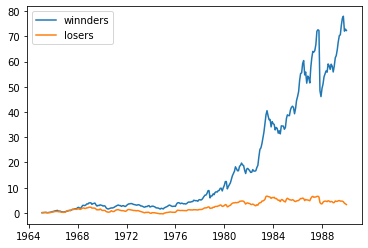

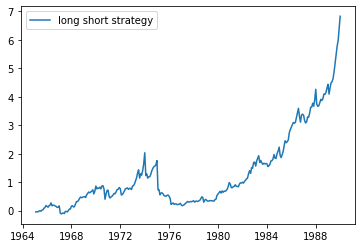

In [16]:
#  6)  Plot the results

# =============================================================================
# Plot the winner loser portfolio and long-short strategy
# =============================================================================
plt.plot(ewretdat3['cumret_winners'])
plt.plot(ewretdat3['cumret_losers'])
plt.legend(['winnders','losers'],loc='upper left')
plt.savefig('winnders_losers.pdf')
plt.show()
plt.close()

plt.plot(ewretdat3['cumret_long_short'])
plt.legend(['long short strategy'],loc='upper left')
plt.savefig('long_short.pdf')
plt.show()
plt.close()